# BÀI THỰC HÀNH 2 – PHÂN LỚP BỆNH TIỂU ĐƯỜNG  
**Giải thuật 1:** Cây quyết định (Decision Tree) & Rừng cây (Random Forest)
---

##  Giới thiệu bài toán

Bài toán đặt ra là **dự đoán một người có mắc bệnh tiểu đường hay không** dựa trên các thông tin nhân khẩu học và sức khoẻ cơ bản.  

Đây là bài toán **phân lớp nhị phân (binary classification)** với:

- **Biến mục tiêu (target)**: `diabetes`
  - `0` : không mắc bệnh tiểu đường  
  - `1` : mắc bệnh tiểu đường  

Mục tiêu của bài thực hành:

- Khảo sát và tiền xử lý bộ dữ liệu tiểu đường.  
- Xây dựng hai mô hình:
  - **Decision Tree**  
  - **Random Forest**  
- Đánh giá và so sánh hiệu năng hai mô hình trên tập kiểm tra.

---

# 1. Import thư viện

In [1]:
# 1. Import thư viện
# ======================================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 2. Đọc dữ liệu

In [ ]:
# ======================================================
# 2. Đọc dữ liệu
# ======================================================

df = pd.read_csv("diabetes_prediction_dataset.csv")

print("Kích thước dữ liệu:", df.shape)
df.head()


Kích thước dữ liệu: (100000, 9)


gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

# 3. Khám phá sơ bộ dữ liệu

In [3]:
# ======================================================
# 3. Khám phá sơ bộ dữ liệu
# ======================================================

print(df.info())
print("\nThống kê mô tả các cột số:")
print(df.describe())

print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Thống kê mô tả các cột số:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26

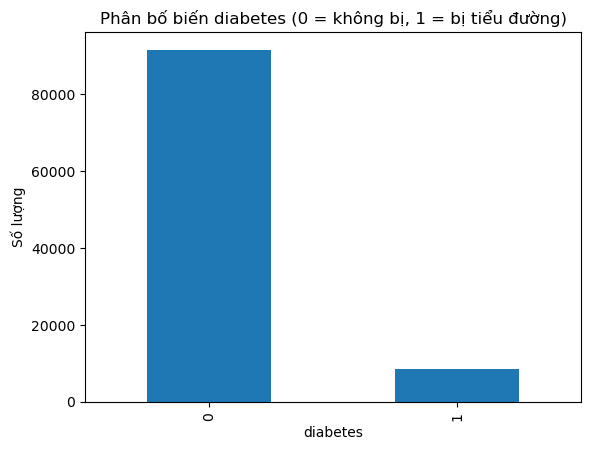

In [4]:
# (Tuỳ chọn) Vẽ phân bố biến mục tiêu diabetes (0/1)
df['diabetes'].value_counts().plot(kind='bar')
plt.title("Phân bố biến diabetes (0 = không bị, 1 = bị tiểu đường)")
plt.xlabel("diabetes")
plt.ylabel("Số lượng")
plt.show()


Dữ liệu sử dụng là bộ **Diabetes Prediction Dataset** trên Kaggle, được đọc từ file  
`diabetes_prediction_dataset.csv`.

- Kích thước dữ liệu: **100000 dòng, 9 cột**.
- Các cột chính:
  - `gender` – giới tính.
  - `age` – tuổi.
  - `hypertension` – có bị cao huyết áp hay không (0/1).
  - `heart_disease` – có bệnh tim hay không (0/1).
  - `smoking_history` – lịch sử hút thuốc.
  - `bmi` – chỉ số BMI.
  - `HbA1c_level` – chỉ số HbA1c.
  - `blood_glucose_level` – lượng đường trong máu.
  - `diabetes` – biến mục tiêu (0: không tiểu đường, 1: có tiểu đường).

Kết quả `df.info()` cho thấy:

- Tất cả các cột đều có **100000 giá trị non-null**, tức là **không có giá trị thiếu**.
- Kiểu dữ liệu:
  - `age`, `bmi`, `HbA1c_level`, `blood_glucose_level` là `float64`.
  - `hypertension`, `heart_disease`, `diabetes` là `int64`.
  - `gender`, `smoking_history` là `object` (chuỗi).

Thống kê mô tả (`df.describe()`) cho thấy:

- Tuổi trung bình khoảng **41.86** tuổi, độ lệch chuẩn khoảng **22.16**.
- Chỉ số BMI trung bình khoảng **27.32**.
- Các chỉ số HbA1c và đường huyết có sự biến thiên khá lớn, phù hợp với bài toán y khoa.

Phân bố biến mục tiêu

Biểu đồ cột của biến `diabetes` cho thấy:

- Số người **không mắc tiểu đường (0)** chiếm đa số.
- Số người **mắc tiểu đường (1)** chỉ chiếm một phần nhỏ.

=> Dữ liệu **bất cân bằng lớp**: lớp 0 nhiều hơn lớp 1 khá nhiều. Khi đánh giá mô hình cần chú ý tới các chỉ số như Recall/F1 cho lớp 1.


# 4. Chọn thuộc tính & Tiền xử lý
-  Các cột chính trong dataset:
    +   gender, age, hypertension, heart_disease,
    +    smoking_history, bmi, HbA1c_level, blood_glucose_level, diabetes

In [5]:
# ======================================================
# 4. Chọn thuộc tính & Tiền xử lý
#    Các cột chính trong dataset:
#    gender, age, hypertension, heart_disease,
#    smoking_history, bmi, HbA1c_level, blood_glucose_level, diabetes
# ======================================================

features = [
    'gender',
    'age',
    'hypertension',
    'heart_disease',
    'smoking_history',
    'bmi',
    'HbA1c_level',
    'blood_glucose_level'
]
target = 'diabetes'

X = df[features].copy()
y = df[target].copy()

# ------------------------------------------------------
# 4.1. Xử lý giá trị thiếu
# ------------------------------------------------------

# Các biến số: điền median
for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    X[col] = X[col].fillna(X[col].median())

# Các biến phân loại: điền mode
for col in ['gender', 'smoking_history']:
    X[col] = X[col].fillna(X[col].mode()[0])

# ------------------------------------------------------
# 4.2. Mã hoá biến phân loại bằng one-hot encoding
# ------------------------------------------------------
X_encoded = pd.get_dummies(X, columns=['gender', 'smoking_history'], drop_first=True)

print("Các cột sau khi mã hoá:")
print(X_encoded.columns)
X_encoded.head()


Các cột sau khi mã hoá:
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Male', 'gender_Other',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current'],
      dtype='object')


age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   gender_Male  gender_Other  smoking_history_current  smoking_history_ever  \
0        False         False                    False                 False   
1        False         False                    False                 False   
2         True         False                    False                 False   
3        False         False                     True                 False   
4         True         False                     True                 False   

   smoking_history_former  smoking_history_never  smoking_history_not current  
0                   False                   True                        False  
1                   False                  False                        False  
2                   False                   True                        False  
3                   False                  False                        False  
4                   False                  False                        False

**Chọn các thuộc tính sau làm **features** đầu vào:**

> `gender`, `age`, `hypertension`, `heart_disease`,  
> `smoking_history`, `bmi`, `HbA1c_level`, `blood_glucose_level`

Biến mục tiêu: **`diabetes`**.

**Xử lý giá trị thiếu**

Kết quả khám phá dữ liệu cho thấy không có giá trị thiếu. Tuy nhiên, trong code vẫn dùng:

- `fillna(median)` cho các cột số (`age`, `bmi`, `HbA1c_level`, `blood_glucose_level`).
- `fillna(mode)` cho các cột phân loại (`gender`, `smoking_history`).

Việc này giúp chương trình an toàn hơn trong trường hợp sau này dữ liệu có thêm bản ghi bị thiếu.

**Mã hoá biến phân loại**

Các cột phân loại `gender` và `smoking_history` được mã hoá bằng **one-hot encoding**:

```python
X_encoded = pd.get_dummies(X, columns=['gender', 'smoking_history'], drop_first=True)

**Dữ liệu sau khi mã hoá**

Sau khi mã hoá one-hot, ta thu được:

- **Các cột số (numerical):**  
  `age`, `hypertension`, `heart_disease`, `bmi`, `HbA1c_level`, `blood_glucose_level`.

- **Các cột nhị phân (dummy variables):**
  - `gender_Male`, `gender_Other`
  - `smoking_history_current`, `smoking_history_ever`,  
    `smoking_history_former`, `smoking_history_never`,  
    `smoking_history_not current`, ...

Tham số `drop_first=True` trong `pd.get_dummies` giúp **bỏ bớt một giá trị** trong mỗi biến phân loại, qua đó **tránh đa cộng tuyến** giữa các cột dummy.


# 5. Chia dữ liệu train/test

In [6]:
# ======================================================
# 5. Chia dữ liệu train/test
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Kích thước tập train:", X_train.shape)
print("Kích thước tập test :", X_test.shape)


Kích thước tập train: (80000, 13)
Kích thước tập test : (20000, 13)



**Dữ liệu sau khi mã hoá được chia thành:**

- **Train set:** 80% số mẫu.  
- **Test set:** 20% số mẫu.

Sử dụng:

```python
train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 6. Mô hình Cây quyết định (Decision Tree)

In [7]:
# ======================================================
# 6. Mô hình Cây quyết định (Decision Tree)
# ======================================================

dt_clf = DecisionTreeClassifier(
    criterion='gini',   # hoặc 'entropy'
    max_depth=5,        # giới hạn độ sâu, có thể chỉnh lại
    random_state=42
)

dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

print("========== DECISION TREE ==========")
print("Accuracy trên tập test:", round(accuracy_score(y_test, y_pred_dt), 4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification report:")
print(classification_report(y_test, y_pred_dt))


========== DECISION TREE ==========
Accuracy trên tập test: 0.9723

Confusion matrix:
[[18300     0]
 [  554  1146]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



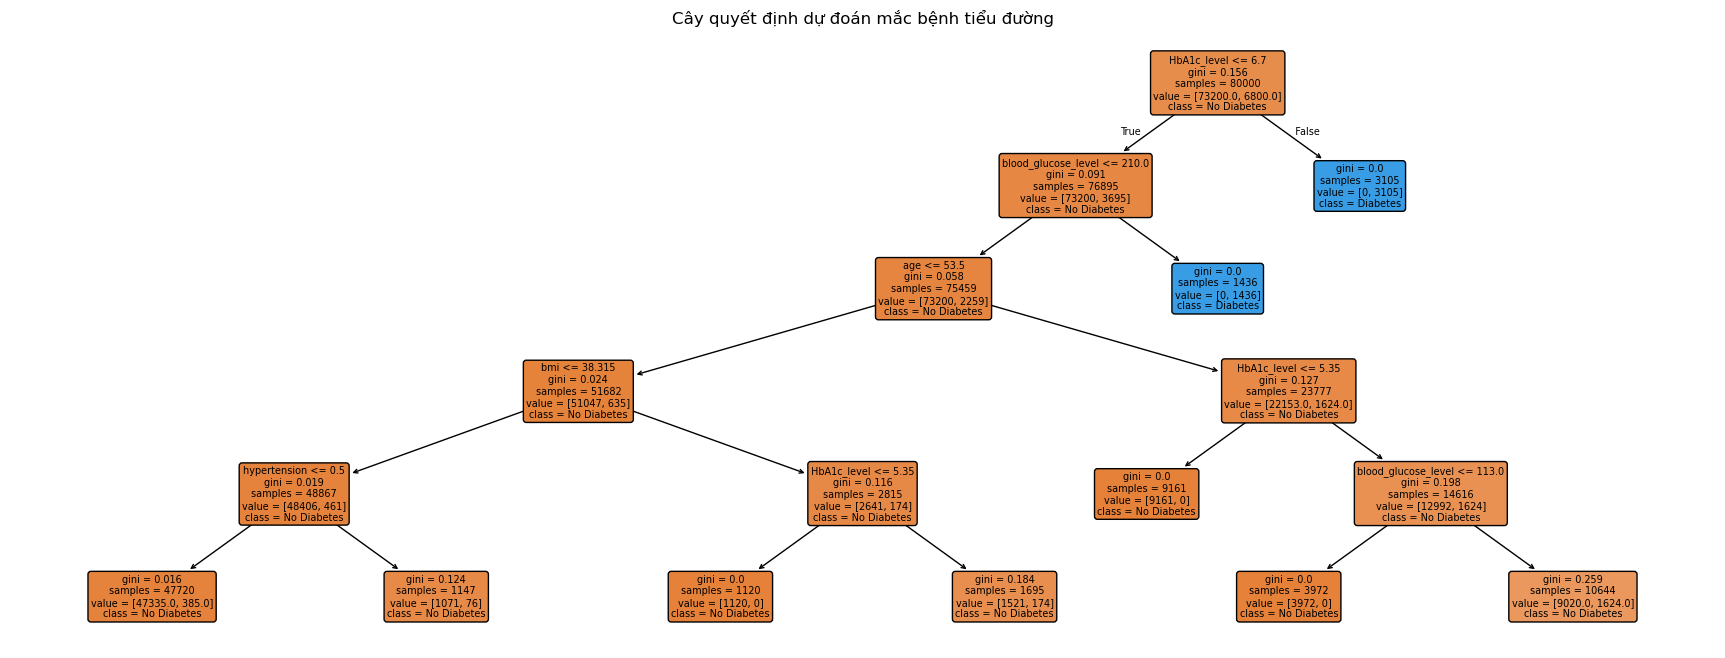

In [8]:
# (Tuỳ chọn) Vẽ cây quyết định để đưa vào báo cáo

plt.figure(figsize=(22, 8))
plot_tree(
    dt_clf,
    feature_names=X_train.columns,
    class_names=["No Diabetes", "Diabetes"],
    filled=True,
    rounded=True,
    fontsize=7
)
plt.title("Cây quyết định dự đoán mắc bệnh tiểu đường")
plt.show()


**Cấu hình mô hình**

Mô hình được khởi tạo bằng:

```python
DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    random_state=42
)
```
Dùng chỉ số Gini để chọn thuộc tính chia.
Giới hạn độ sâu cây max_depth = 5 để giảm overfitting.

**Kết quả trên tập test**

**Accuracy:** 0.9723 ≈ **97.23%**

 **Confusion Matrix**

|               | Dự đoán 0 | Dự đoán 1 |
|---------------|-----------|-----------|
| **Thực 0**    | 18380     | 0         |
| **Thực 1**    | 554       | 1146      |

- 18 380 người không tiểu đường được dự đoán đúng, 0 người không bệnh bị dự đoán nhầm.
- 1 146 người bị tiểu đường được dự đoán đúng.
- 554 người bị tiểu đường nhưng bị dự đoán nhầm là không bệnh (FN).

**Classification Report**

Lớp 0 – Không tiểu đường
- **Precision:** 0.97  
- **Recall:** 1.00  
- **F1-score:** 0.99  

Lớp 1 – Tiểu đường
- **Precision:** 1.00  
- **Recall:** 0.67  
- **F1-score:** 0.81  

**Nhận xét**

- Cây quyết định dự đoán **rất tốt lớp 0**, hầu như không bỏ sót người không bệnh.  
- Đối với lớp 1, mô hình có **Precision rất cao** (dự đoán bệnh thì gần như chắc chắn bệnh), nhưng **Recall chỉ 0.67**, nghĩa là vẫn còn **bỏ sót bệnh nhân (FN)**.


# 7. Mô hình Rừng cây (Random Forest)

In [10]:
# ======================================================
# 7. Mô hình Rừng cây (Random Forest)
# ======================================================

rf_clf = RandomForestClassifier(
    n_estimators=200,   # số cây, có thể chỉnh 100/200 tuỳ bạn
    max_depth=None,
    random_state=42
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("========== RANDOM FOREST ==========")
print("Accuracy trên tập test:", round(accuracy_score(y_test, y_pred_rf), 4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification report:")
print(classification_report(y_test, y_pred_rf))


========== RANDOM FOREST ==========
Accuracy trên tập test: 0.9705

Confusion matrix:
[[18239    61]
 [  530  1170]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.95      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000





**Cấu hình mô hình**

- Sử dụng **200 cây quyết định** trong rừng.
- **max_depth = None** → không giới hạn độ sâu cây, giúp mô hình linh hoạt hơn.

---

**Kết quả trên tập test**

**Accuracy:** **0.9705** ≈ **97.05%**

---

**✔️ Confusion Matrix**

|                 | Dự đoán: Không bệnh | Dự đoán: Bệnh |
|-----------------|----------------------|----------------|
| **Thực tế: Không bệnh** | **18,339** | **61** |
| **Thực tế: Bệnh**       | **530**    | **1,170** |

- **18,339** người *không bệnh* được dự đoán đúng  
- **61** người *không bệnh* bị dự đoán nhầm là bệnh (FP)  
- **1,170** người *bệnh* được dự đoán đúng  
- **530** người *bệnh* bị dự đoán nhầm là không bệnh (FN)

---

**✔️ Classification Report**

**Lớp 0 – Không tiểu đường**
- Precision: **0.97**
- Recall: **1.00**
- F1-score: **0.98**

**Lớp 1 – Tiểu đường**
- Precision: **0.95**
- Recall: **0.69**
- F1-score: **0.80**
---
**Nhận xét**

- Accuracy của Random Forest **gần tương đương** Decision Tree (97.05% vs 97.23%).
- So với Decision Tree, Random Forest:
  - **Giảm FN** (người bệnh đoán nhầm thành không bệnh): **530 vs 554**
  - Nhưng **tăng FP** (người không bệnh đoán nhầm thành bệnh): **61 vs 0**

# 8. Độ quan trọng của thuộc tính (Feature Importance)

Độ quan trọng của các thuộc tính:
HbA1c_level                    0.397500
blood_glucose_level            0.327924
bmi                            0.122168
age                            0.102162
hypertension                   0.014527
heart_disease                  0.010487
gender_Male                    0.006820
smoking_history_never          0.005225
smoking_history_former         0.004395
smoking_history_current        0.003207
smoking_history_not current    0.002892
smoking_history_ever           0.002688
gender_Other                   0.000003
dtype: float64


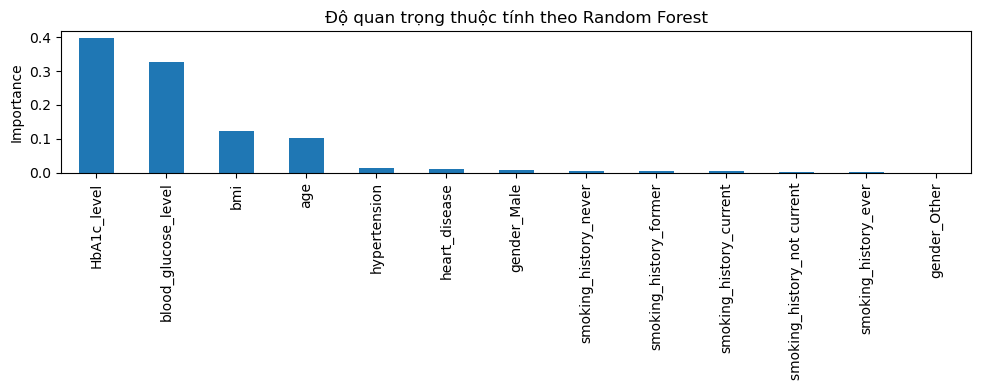

In [11]:
# ======================================================
# 8. Độ quan trọng của thuộc tính (Feature Importance)
# ======================================================

importances = rf_clf.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

print("Độ quan trọng của các thuộc tính:")
print(feat_imp)

plt.figure(figsize=(10, 4))
feat_imp.plot(kind='bar')
plt.title("Độ quan trọng thuộc tính theo Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


## **Độ quan trọng của thuộc tính (Feature Importance)**

Random Forest cho biết mức độ quan trọng của từng thuộc tính:

### **Các thuộc tính quan trọng nhất**
- **HbA1c_level** (~0.40)
- **blood_glucose_level** (~0.33)
- **bmi**
- **age**

## **Mức quan trọng thấp hơn**
- **hypertension**
- **heart_disease**
- Các thuộc tính về giới tính và lịch sử hút thuốc:
  - `gender_*`
  - `smoking_history_*`

---

## **Kết luận**

Các chỉ số xét nghiệm đường huyết và HbA1c có ảnh hưởng mạnh nhất đến quyết định dự đoán của mô hình — điều này hoàn toàn phù hợp với thực tế lâm sàng khi chẩn đoán bệnh tiểu đường.

---


# 9. In nhanh kết luận so sánh hai mô hình

In [12]:
# ======================================================
# 9. In nhanh kết luận so sánh hai mô hình
# ======================================================

acc_dt = accuracy_score(y_test, y_pred_dt)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy Decision Tree : {acc_dt:.4f}")
print(f"Accuracy Random Forest : {acc_rf:.4f}")

if acc_rf > acc_dt:
    print("=> Random Forest cho kết quả tốt hơn Decision Tree trên tập test.")
elif acc_rf < acc_dt:
    print("=> Decision Tree cho kết quả tốt hơn Random Forest trên tập test.")
else:
    print("=> Hai mô hình cho độ chính xác tương đương trên tập test.")


Accuracy Decision Tree : 0.9723
Accuracy Random Forest : 0.9705
=> Decision Tree cho kết quả tốt hơn Random Forest trên tập test.


## So sánh và Kết luận

### Decision Tree
- **Accuracy:** 97.23% (nhỉnh hơn một chút so với Random Forest).
- **FP = 0:** Không dự đoán nhầm người khỏe thành bệnh.
- **FN = 554:** Bỏ sót khá nhiều bệnh nhân bị tiểu đường.
- **Ưu điểm:**  
  - Cây quyết định **dễ hiểu**, **dễ trực quan hóa**, phù hợp giải thích mô hình.
  
---

### Random Forest
- **Accuracy:** 97.05% (gần tương đương Decision Tree).
- **FP = 61:** Một số người khỏe bị dự đoán sai là bệnh.
- **FN = 530:** Bỏ sót bệnh nhân **ít hơn** Decision Tree.
- **Ưu điểm:**  
  - Cho **độ quan trọng thuộc tính** ổn định hơn.
  - Tính tổng hợp của nhiều cây giúp mô hình tổng quát tốt hơn.

---

## Kết luận

- Nếu chỉ xét tiêu chí **Accuracy**, thì **Decision Tree** cho kết quả tốt hơn một chút và được chọn trong bài thực hành.
- Tuy nhiên, khi xét về việc **giảm số bệnh nhân bị bỏ sót (FN)** — vốn rất quan trọng trong y tế — Random Forest lại **an toàn hơn**.
- Tùy mục tiêu ứng dụng thực tế mà lựa chọn:
  - **Ưu tiên chính xác tổng thể → Decision Tree**
  - **Ưu tiên giảm bỏ sót bệnh nhân, cân bằng FP/FN → Random Forest**
- Có thể cải thiện thêm bằng cách:
  - Điều chỉnh **siêu tham số** (max_depth, class_weight…)
  - **Thay đổi threshold** dự đoán
  - Dùng các mô hình mạnh hơn như XGBoost, LightGBM.

